In [25]:
import tensorflow as tf
import keras
from keras import layers
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomBrightness, RandomCrop
import os
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
from tensorflow.keras.applications import EfficientNetB0
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import roc_curve, auc

In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
data_path = r'/content/drive/MyDrive/RealWaste'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    data_path,
    image_size=(224, 224),
    batch_size=32,

)


Found 4752 files belonging to 9 classes.


In [28]:
class_names = sorted(os.listdir(data_path))  # Get folder names
num_classes = len(class_names)

In [29]:
data_augmentation = tf.keras.Sequential([
    RandomFlip("horizontal"),   # Randomly flip images horizontally
    RandomRotation(0.4),         # Randomly rotate images by up to 20%
    RandomZoom(0.4),             # Randomly zoom into images by 20%
    RandomBrightness(factor=0.4),        # Randomly increase the brightness
    RandomCrop(150,160)
])

# Apply augmentation to the training data
def augment(image, label):
    image = data_augmentation(image)
    image = tf.image.resize(image, (224, 224))
    return image , label



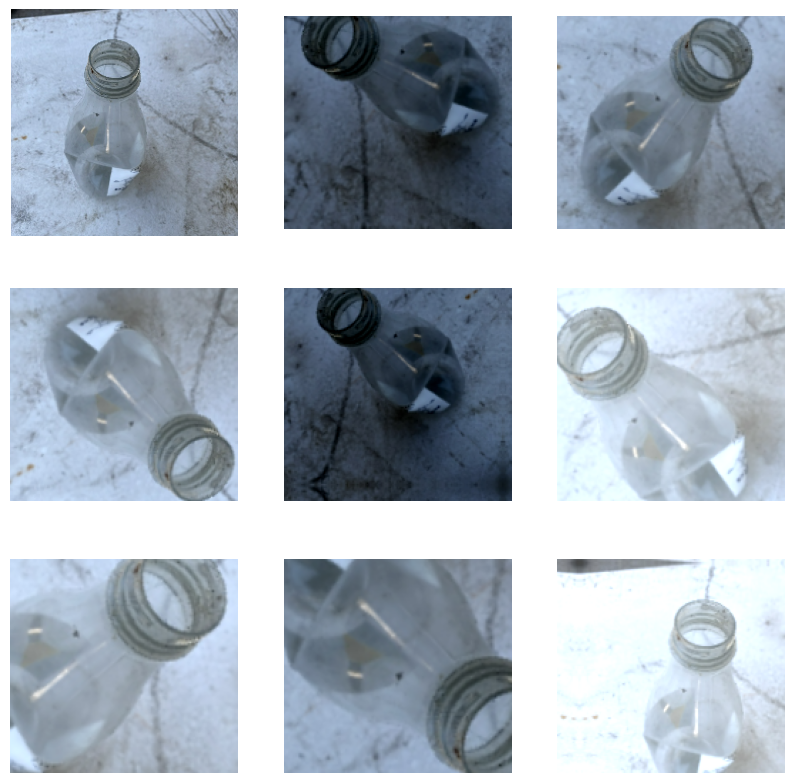

In [30]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):
          image = images[0]  # Select the first image in the batch

        # Apply augmentation multiple times to the same image
    augmented_images = [image]
    for _ in range(8):  # Create 8 augmented versions
        augmented_images.append(data_augmentation(image[tf.newaxis, ...])[0])

        # Display the original and augmented images
    for i in range(9):  # Display 9 images (1 original + 8 augmented)
        ax = plt.subplot(3, 3, i + 1)
        img = augmented_images[i].numpy().astype("uint8")
        plt.imshow(img)
        plt.axis("off")

    plt.show()

# Call the function to visualize data augmentation
visualize_dataset(dataset, class_names)

In [31]:
def normalize_img(image, label):
    image = image/ 255.0  # Scale pixel values to [0, 1]
    label = tf.one_hot(label, num_classes)
    return image, label




In [32]:
dataset_size = tf.data.experimental.cardinality(dataset).numpy()

In [33]:
# Shuffle and split the dataset into train, validation, and test sets
train_size = int(0.7 * dataset_size)  # 70% for training
val_size = int(0.15 * dataset_size)   # 15% for validation
test_size = dataset_size - train_size - val_size  # 15% for testing

train_dataset = dataset.take(train_size).map(augment).map(normalize_img)
val_dataset = dataset.skip(train_size).take(val_size).map(normalize_img)
test_dataset = dataset.skip(train_size + val_size).map(normalize_img)



In [34]:
# Get one batch from the dataset
for images, labels in train_dataset.take(1):
    print("Image batch shape:", images.shape)
    print("Label batch shape:", labels.shape)

Image batch shape: (32, 224, 224, 3)
Label batch shape: (32, 9)


In [35]:
for images, labels in train_dataset.take(1):
    print(f"Min pixel value: {tf.reduce_min(images).numpy()}")
    print(f"Max pixel value: {tf.reduce_max(images).numpy()}")

Min pixel value: 0.0
Max pixel value: 1.0


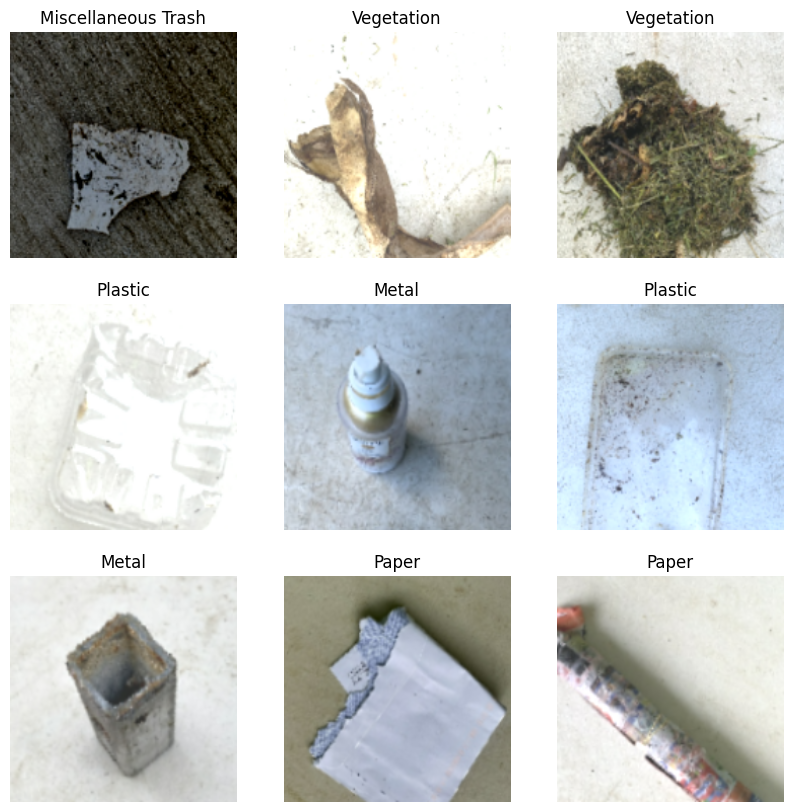

In [36]:
def visualize_dataset(dataset, class_names):
    plt.figure(figsize=(10, 10))
    for images, labels in dataset.take(1):  # Get one batch
        for i in range(9):  # Show 9 images
            ax = plt.subplot(3, 3, i + 1)
            img = images[i].numpy()
            plt.imshow(img)
            label_idx = tf.argmax(labels[i]).numpy()  # Extract class index from one-hot label
            plt.title(class_names[label_idx])
            plt.axis("off")
    plt.show()

# Visualize data augmentation results
visualize_dataset(train_dataset, class_names)

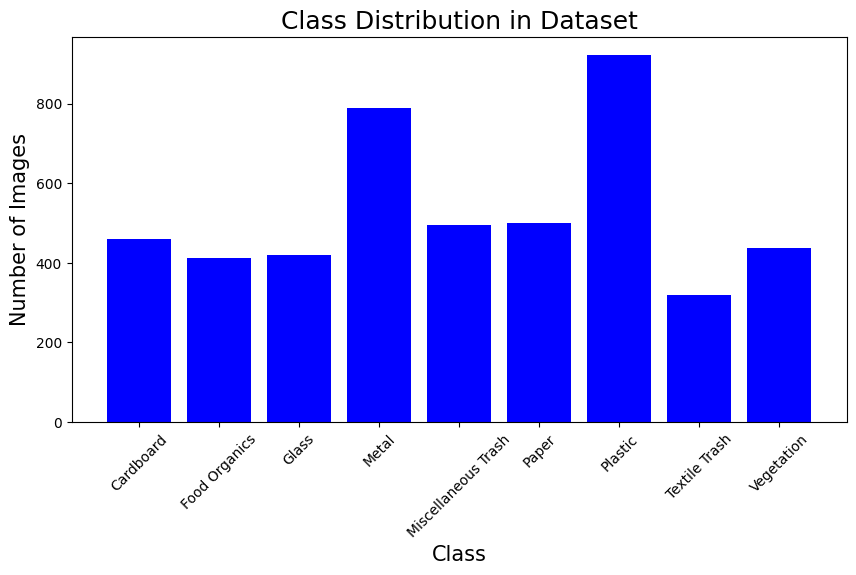

In [37]:


# Count number of images in each class
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name)))
                for class_name in class_names}

# Plot the class distribution
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values(), color='blue')
plt.xticks(rotation=45)
plt.xlabel("Class", fontsize = 15 )
plt.ylabel("Number of Images", fontsize = 15 )
plt.title("Class Distribution in Dataset", fontsize = 18 )
plt.show()

In [38]:


# Ensure eager execution is enabled
tf.compat.v1.enable_eager_execution()

# Iterate over batches of the training dataset
train_labels = []

# Use .as_numpy_iterator() to convert the TensorFlow dataset to numpy
for batch in train_dataset.as_numpy_iterator():
    labels = batch[1]  # Extract the labels (second element of the batch)

    # If labels are one-hot encoded, convert to class indices
    if labels.ndim > 1:
        labels = np.argmax(labels, axis=1)  # Convert one-hot to class indices

    train_labels.extend(labels)  # Add the labels to the list

# Convert the list of labels into a numpy array
train_labels = np.array(train_labels)

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(train_labels), y=train_labels)
class_weights_dict = {i: weight for i, weight in enumerate(class_weights)}

# Print out class weights (for reference)
print("Class weights:", class_weights_dict)



Class weights: {0: np.float64(1.1889960700250088), 1: np.float64(1.32536837913182), 2: np.float64(1.2707140129820542), 3: np.float64(0.6603174603174603), 4: np.float64(1.1137884872824633), 5: np.float64(1.0048309178743962), 6: np.float64(0.5628276678504989), 7: np.float64(1.7198966408268734), 8: np.float64(1.1738977072310406)}


In [39]:
base_model = EfficientNetB0(weights="imagenet", include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False  # Freeze the base model

# Build the model
model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.5),
    layers.Dense(256, activation="relu"),
    layers.Dense(9, activation="softmax")  # Adjust for the number of classes
])

# Compile the model
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])




# Train only on the small batch
history = model.fit(train_dataset, validation_data=val_dataset, epochs=5, class_weight=class_weights_dict)



Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 430s 4s/step - accuracy: 0.1104 - loss: 2.2213 - val_accuracy: 0.0653 - val_loss: 2.2101
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 434s 4s/step - accuracy: 0.1059 - loss: 2.2134 - val_accuracy: 0.0682 - val_loss: 2.2148
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 401s 4s/step - accuracy: 0.0949 - loss: 2.2197 - val_accuracy: 0.0668 - val_loss: 2.2133
Epoch 4/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 391s 4s/step - accuracy: 0.1127 - loss: 2.1979 - val_accuracy: 0.1009 - val_loss: 2.2016
Epoch 5/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 404s 4s/step - accuracy: 0.0972 - loss: 2.2143 - val_accuracy: 0.0980 - val_loss: 2.2026
Epoch 1/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 681s 6s/step - accuracy: 0.1367 - loss: 2.2238 - val_accuracy: 0.0639 - val_loss: 2.2066
Epoch 2/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 692s 6s/step - accuracy: 0.1522 - loss: 2.1964 - val_accuracy: 0.1719 - val_loss: 2.1813
Epoch 3/5
104/104 ━━━━━━━━━━━━━━━━━━━━ 652s 6s/step - accuracy: 0.1651 - loss: 2.1705 - val_accuracy: 0.

In [ ]:
# Fine-tuning (optional)
base_model.trainable = True
for layer in base_model.layers[:100]:  # Freeze first 100 layers
    layer.trainable = False

# Recompile after unfreezing
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.00001),
              loss="categorical_crossentropy",
              metrics=["accuracy"])

# Train again on the small batch
history_fine_tune = model.fit(train_dataset, validation_data=val_dataset, epochs=5, class_weight=class_weights_dict)


In [40]:
# Get true labels and predictions
y_true = []
y_pred_probs = []

for images, labels in val_dataset:
    preds = model.predict(images)  # Get predicted probabilities
    y_true.extend(np.argmax(labels.numpy(), axis=1))  # Convert one-hot labels to class indices
    y_pred_probs.extend(preds)  # Store predicted probabilities

y_pred_probs = np.array(y_pred_probs)
y_true = np.array(y_true)

# Convert probabilities to class predictions
y_pred = np.argmax(y_pred_probs, axis=1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [41]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.15      0.06      0.08        72
           1       0.50      0.05      0.09        77
           2       0.16      0.71      0.26        62
           3       0.32      0.06      0.09       109
           4       0.15      0.16      0.15        77
           5       0.15      0.24      0.19        68
           6       0.12      0.02      0.03       120
           7       0.13      0.38      0.20        53
           8       0.52      0.23      0.32        66

    accuracy                           0.17       704
   macro avg       0.25      0.21      0.16       704
weighted avg       0.24      0.17      0.14       704



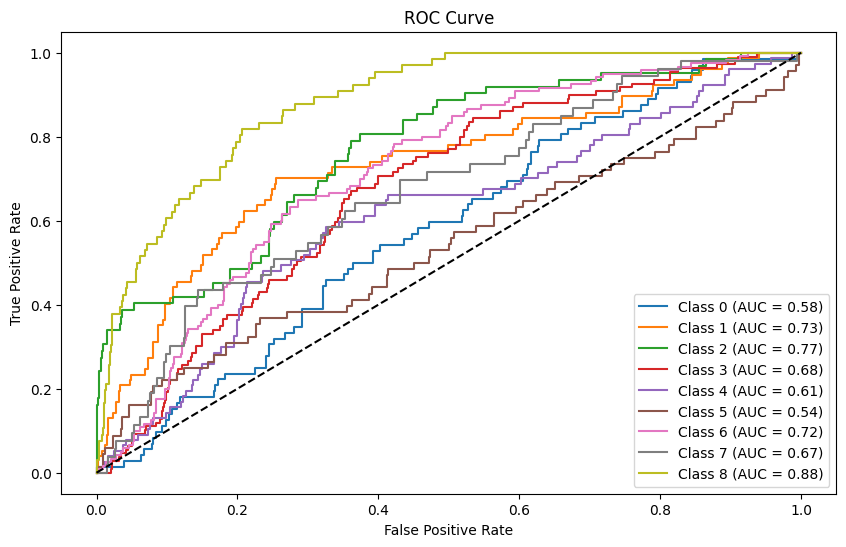

In [42]:

# Convert true labels to one-hot encoding
num_classes = 9  # Adjust to your number of classes
y_true_one_hot = to_categorical(y_true, num_classes)

# Plot ROC Curve for each class
plt.figure(figsize=(10, 6))

for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

# Plot baseline
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

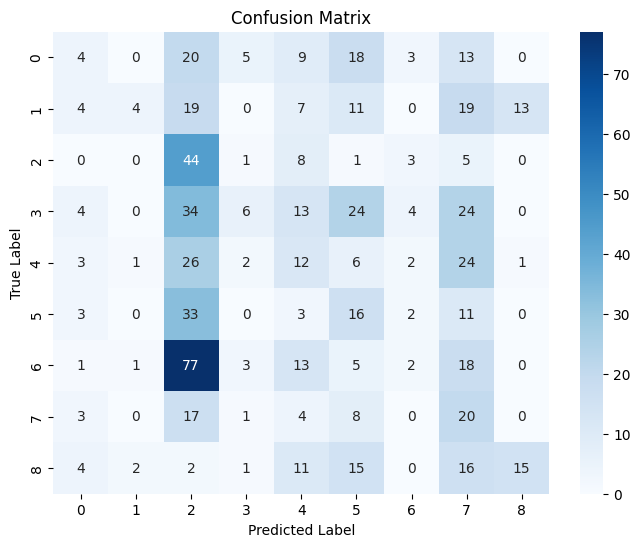

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


In [44]:
# Evaluate on the test dataset
test_loss, test_acc = model.evaluate(test_dataset)

print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")


23/23 ━━━━━━━━━━━━━━━━━━━━ 85s 3s/step - accuracy: 0.1829 - loss: 2.0733
Test Accuracy: 0.1806
Test Loss: 2.0629


In [45]:

# Get the true labels and predicted labels
y_true_t = []
y_pred_probs_t = []
for images, labels in test_dataset:
    y_true_t.extend(np.argmax(labels.numpy(), axis=-1))  # Store true labels
    y_pred_probs_t.extend(model.predict(images))  # Get predictions

# Convert softmax probabilities to class labels
y_pred_t = np.argmax(y_pred_probs_t, axis=1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


In [46]:


print(classification_report(y_true_t, y_pred_t))


              precision    recall  f1-score   support

           0       0.11      0.04      0.06        67
           1       0.50      0.15      0.23        72
           2       0.16      0.64      0.25        66
           3       0.22      0.04      0.06       106
           4       0.17      0.16      0.16        83
           5       0.17      0.30      0.22        70
           6       0.31      0.03      0.06       148
           7       0.13      0.38      0.20        50
           8       0.57      0.22      0.32        58

    accuracy                           0.18       720
   macro avg       0.26      0.22      0.17       720
weighted avg       0.26      0.18      0.15       720



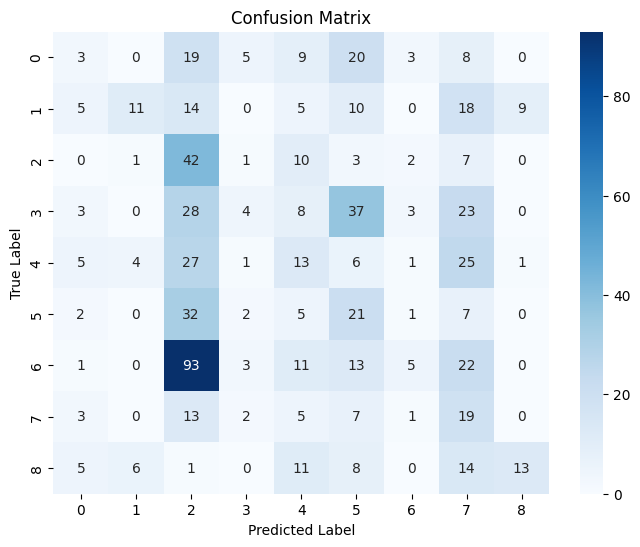

In [47]:

# Compute confusion matrix
cm = confusion_matrix(y_true_t, y_pred_t)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(9), yticklabels=range(9))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

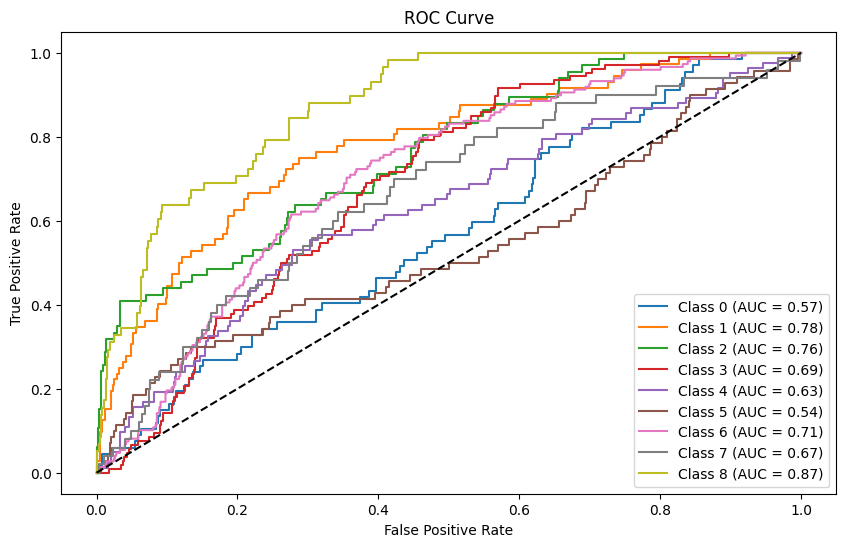

In [48]:
num_classes = 9  # Adjust for your dataset
y_true_one_hot = to_categorical(y_true_t, num_classes)

plt.figure(figsize=(10, 6))
for i in range(num_classes):
    fpr, tpr, _ = roc_curve(y_true_one_hot[:, i], np.array(y_pred_probs_t)[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'Class {i} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
